$$
G=[0; 1] \times [0; 1]
$$
$$
Q_T = G \times [0; T]
$$
$$
\begin{cases}
{u_t = a \Delta u + (1 + 2at \pi^2)\sin(\pi x) \sin(\pi y)} \\
{u(x, y, 0) = 0} \\
{u(0, y, t) = u(1, y, t) = u(x, 0, t) = u(x, 1, t) = 0}
\end{cases}
$$
$$
u\left(x,\ y,\ t\right)=t\sin\left(\pi x\right)\sin\left(\pi y\right)
$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.sparse import diags
from scipy.sparse.linalg import spsolve

In [2]:
a = 1

In [3]:
T = 1
h, tau = 0.01, 0.01

In [4]:
Nx, Nt = int(1 / h), int(T / tau)
Nx, Nt

(100, 100)

In [5]:
x = np.linspace(0, 1, Nx)
y = np.linspace(0, 1, Nx)
t = np.linspace(0, T, Nt + 1)

In [6]:
u = np.zeros((Nx, Nx, Nt + 1))

In [7]:
def build_matrix(size, coeff):
    diagonals = [-coeff * np.ones(size - 1), 
                 (1 + 2 * coeff) * np.ones(size), 
                 -coeff * np.ones(size - 1)]
    return diags(diagonals, [-1, 0, 1], format='csc')

In [8]:
coeff_x = a * tau / (2 * h ** 2)
A_x = build_matrix(Nx, coeff_x)

In [9]:
for n in range(Nt):
    tn = n * tau
    tn_half = tn + tau / 2
    
    # Шаг 1
    u_half = np.zeros_like(u[:, :, 0])
    
    for j in range(1, Nx - 1):
        # Правая часть
        rhs = u[:, j, n] + (a * tau / 2) * (u[:, j + 1, n] - 2 * u[:, j, n] + u[:, j - 1, n]) / h**2
        rhs += tau / 2 * np.sin(np.pi * x) * np.sin(np.pi * y[j]) * (1 + 2 * a * tn * np.pi**2)
        
        # Граничные условия
        rhs[0] = rhs[-1] = 0
        
        # Решение системы
        u_half[:, j] = spsolve(A_x, rhs)
    
    # Шаг 2
    u_next = np.zeros_like(u[:, :, 0])
    
    for i in range(1, Nx - 1):
        # Правая часть
        rhs = u_half[i, :] + (a * tau / 2) * (u_half[i + 1, :] - 2 * u_half[i, :] + u_half[i - 1, :]) / h**2
        rhs += tau / 2 * np.sin(np.pi * x[i]) * np.sin(np.pi * y) * (1 + 2 * a * tn_half * np.pi**2)
        
        # Граничные условия
        rhs[0] = rhs[-1] = 0
        
        # Решение системы
        u_next[i, :] = spsolve(A_x, rhs)
    
    u[:, :, n + 1] = u_next

In [10]:
def exact_solution(x, y, t):
    return t * np.sin(np.pi * x) * np.sin(np.pi * y)

u_exact = np.zeros((Nx, Nx, Nt + 1))
for n in range(Nt + 1):
    for i in range(Nx):
        for j in range(Nx):
            u_exact[i, j, n] = exact_solution(x[i], y[j], n * tau)

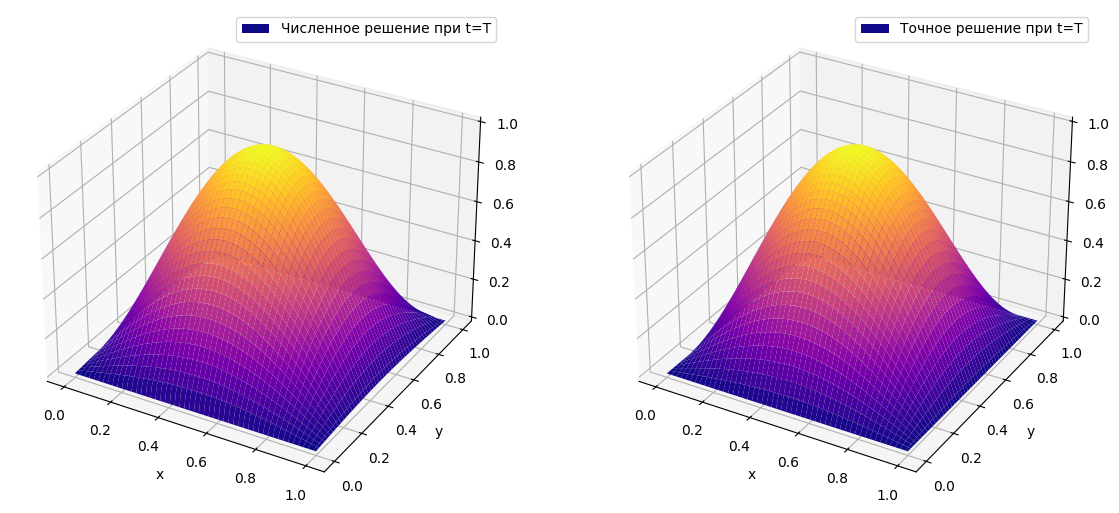

In [11]:
fig = plt.figure(figsize=(14, 8))

ax = fig.add_subplot(121, projection='3d')

X_g, Y_g = np.meshgrid(x, y)

ax.plot_surface(X_g, Y_g, u[:,:,-1], cmap='plasma', label='Численное решение при t=T')

ax.set_xlabel('x')
ax.set_ylabel('y')

plt.legend()

ax = fig.add_subplot(122, projection='3d')

X_g, Y_g = np.meshgrid(x, y)

ax.plot_surface(X_g, Y_g, u_exact[:,:,-1], cmap='plasma', label='Точное решение при t=T')

ax.set_xlabel('x')
ax.set_ylabel('y')

plt.legend()

plt.show()

In [12]:
error = np.abs(u - u_exact).max()
print(f"Максимальная ошибка: {error:.4f}")

Максимальная ошибка: 0.0299
